In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split

In [2]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
if not use_cuda:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [3]:
# define training and test data directories
data_dir = 'C:/Users/Dylan/Downloads/flowers/flowers'

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [4]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

all_data = datasets.ImageFolder(data_dir, transform=data_transform)

# Create test set using: sklearn.model_selection.train_test_split(random_state=1)
train_set, test_set = train_test_split(all_data, test_size=0.2, random_state=1)

# Creating data indices for training and validation splits:
validation_split = .2
shuffle_dataset = True
random_seed= 42

dataset_size = len(train_set)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
                                                sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = batch_size , num_workers=num_workers)


# print out some data stats
print('Num training images: ', len(train_sampler))
print('Num validation images: ', len(valid_sampler))
print('Num test images: ', len(test_set))

Num training images:  2767
Num validation images:  691
Num test images:  865


<ipython-input-5-a56dd8496b99>:11: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


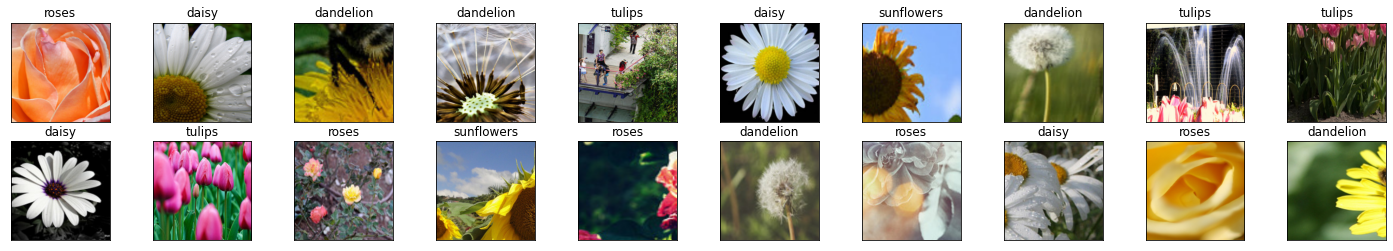

In [5]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert from Tensor images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes the color channel is the third dimension
    # we need to convert（channels,imagesize,imagesize）to（imagesize,imagesize,channels）, so plt.show() can show the image。
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [6]:
##### Define the Model ########
#### To define a Transfer Learning Model for training we'll follow these steps:

### Step 1: Load in a pre-trained VGG16 model
### Step 2: "Freeze" all the parameters of "feature" layers, so the net acts as a fixed feature extractor
### Step 3: Remove the last layer
### Step 4: Replace the last layer with a linear classifier of our own

### Here, "Freezing" simply means that the parameters in the pre-trained model will not change during training.

## Once we have the pre-trained feature extractor, we just need to modify and/or add to the final, fully-connected classifier 
## layers. So we need to  replace the last layer in the vgg classifier group of layers.

## The last layer should see as input the number of features produced by the portion of the network that we are not changing, 
## and produce an appropriate number of outputs for the flower classification task.

## We can access any layer in a pretrained network by name and (sometimes) number, i.e. vgg16.classifier[6] is the sixth layer
## in a group of layers named "classifier".

## Here we add a last linear layer that maps n_inputs -> 5 flower classes 
## new layers automatically have requires_grad = True, so the parameters in the new layers can be changed 



## Specify model architecture 
# Load the pretrained model from pytorch
model_transfer = models.vgg16(pretrained=True)
    
# print out the model structure
print(model_transfer)

print(model_transfer.classifier[6].in_features) 
print(model_transfer.classifier[6].out_features)


# Freeze training for all "features" layers, so the parameters of "features" layers in the pre-trained model will not change 
# during training, we will noly change the "classifier" layers
for param in model_transfer.features.parameters():
    param.requires_grad = False
    
## add a new last linear layer that maps n_inputs -> 5 flower classes
## new layers automatically have requires_grad = True
n_inputs = model_transfer.classifier[6].in_features
new_last_layer = nn.Linear(n_inputs, len(classes))
model_transfer.classifier[6] = new_last_layer

print(model_transfer.classifier[6])
if use_cuda:
    model_transfer = model_transfer.cuda()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
##### Specify Loss Function and Optimizer #####
### Below we'll use cross-entropy loss and stochastic gradient descent (SGD) with a small learning rate. Note that the optimizer 
### accepts as input only the trainable parameters vgg.classifier.parameters().

##### vgg16 is composed of "features" layers and "classifier" layers, here we only optimize the "classifier" layers
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion_transfer = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
# we only optimize the "classifier" layers
optimizer_transfer = optim.SGD(model_transfer.classifier.parameters(), lr=0.001)

In [8]:
# create dictionary for all loaders in transfer learning 
loaders_transfer = {}
loaders_transfer['train'] = train_loader
loaders_transfer['valid'] = validation_loader
loaders_transfer['test'] = test_loader

In [9]:
# train the model
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model_transfer(data)
            # calculate the batch loss
            loss = criterion_transfer(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update average training loss
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            #train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model_transfer(data)
            # calculate the batch loss
            loss = criterion_transfer(output, target)
            # update average validation loss 
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            #valid_loss += loss.item()*data.size(0)
    

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                  valid_loss_min,
                  valid_loss))
            torch.save(model.state_dict(), 'model_transfer.pt')
            valid_loss_min = valid_loss    
    # return trained model
    return model

#### Call the "train" function and get the updated model_transfer
model_transfer = train(4, loaders_transfer, model_transfer, optimizer_transfer, 
                      criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))            

Epoch: 1 	Training Loss: 1.234198 	Validation Loss: 0.943205
Validation loss decreased (inf --> 0.943205).  Saving model ...
Epoch: 2 	Training Loss: 0.868933 	Validation Loss: 0.763272
Validation loss decreased (0.943205 --> 0.763272).  Saving model ...
Epoch: 3 	Training Loss: 0.757642 	Validation Loss: 0.691555
Validation loss decreased (0.763272 --> 0.691555).  Saving model ...
Epoch: 4 	Training Loss: 0.678582 	Validation Loss: 0.653621
Validation loss decreased (0.691555 --> 0.653621).  Saving model ...


<All keys matched successfully>

In [21]:
##### Test the Model #######
### Try out my model on the test dataset of flower images
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.663704


Test Accuracy: 76% (663/865)


<ipython-input-25-ee98f6582376>:20: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


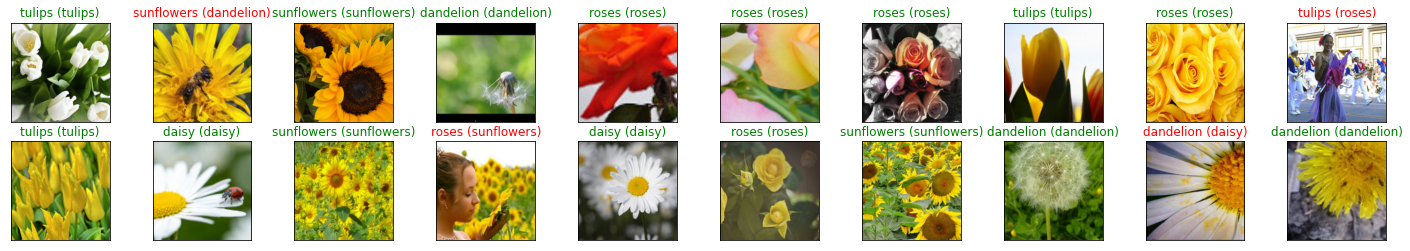

In [25]:
##### Visualize Sample Test Results #####
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if use_cuda:
    images = images.cuda()

# get sample outputs
output = model_transfer(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))